<a href="https://colab.research.google.com/github/RohitGanji/fine-tuning-darts/blob/main/Fine_Tuning_DARTS_for_Image_Classification_Paper_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning DARTS for Image Classification - Paper Implementation

The paper can be foud [here](https://arxiv.org/pdf/2006.09042.pdf).

# Dataset Prepraration and Processing

## Data collection

Let's import the **Fashion MNIST** dataset from `tensorflow.keras.datasets`

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

There are 70000 grayscale images split it train and test set in the ratio 6:1 with each image having a dimension of 28x28 pixels.

## Data visualization

Let's try to visualize the dataset. We'll be using `matplotlib.pyplot` for this process.

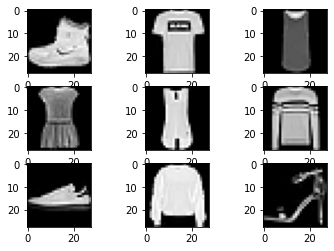

In [2]:
import matplotlib.pyplot as plt

for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## Data transformation

The data needs to be converted to `float32` and reshaped to `(28, 28, 1)` for our model to work with it.

In [3]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [4]:
X_train = X_train.astype("float32").reshape(-1, 28, 28, 1) / 255.
X_test = X_test.astype("float32").reshape(-1, 28, 28, 1) / 255.

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [5]:
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

# Dataset Splitting

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rescale=1/255.,
                                     rotation_range=2.0,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     validation_split=0.2)

train_datagen = train_generator.flow(X_train, y_train,
                                     batch_size=32,
                                     shuffle=False,
                                     subset='training')

valid_datagen = train_generator.flow(X_train, y_train,
                                     batch_size=32,
                                     shuffle=False,
                                     subset='validation')

test_generator = ImageDataGenerator(rescale=1/255.)

test_datagen = test_generator.flow(X_test, y_test,
                                   batch_size=32,
                                   shuffle=False)

# Modeling

## Building

In [8]:
import tensorflow as tf
from keras import layers

input_layer = layers.Input(shape=(28,28,1), name="Input_Layer")

conv2d_1 = layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_1")(input_layer)
batch_norm_1 = layers.BatchNormalization(name="Batch_Normalization_1")(conv2d_1)
relu_1 = layers.Activation(activation="relu", name="ReLU_1")(batch_norm_1)

conv2d_2 = layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_2")(relu_1)
batch_norm_2 = layers.BatchNormalization(name="Batch_Normalization_2")(conv2d_2)
relu_2 = layers.Activation(activation="relu", name="ReLU_2")(batch_norm_2)

conv2d_3 = layers.Conv2D(filters=32, kernel_size=3, padding="same", name="Conv2D_3")(relu_2)
batch_norm_3 = layers.BatchNormalization(name="Batch_Normalization_3")(conv2d_3)

attention_1 = layers.Attention(name="Attention_1")([batch_norm_2, batch_norm_3])
attention_2 = layers.Attention(name="Attention_2")([batch_norm_3, attention_1])
attention_3 = layers.Attention(name="Attention_3")([attention_1, attention_2])
attention_4 = layers.Attention(name="Attention_4")([attention_2, attention_3])

pooling = layers.MaxPooling2D(pool_size=(3,3), name="MaxPooling2D")(attention_4)
flatten = layers.Flatten(name="Flatten")(pooling)
dense_1 = layers.Dense(64, activation="relu", name="Dense_1")(flatten)

output_layer = layers.Dense(num_classes, activation="softmax", name="Output_Layer")(dense_1) 

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

## Compiling

In [9]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
             metrics=["accuracy"])

## Summary & Plotting

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
Conv2D_1 (Conv2D)               (None, 28, 28, 32)   320         Input_Layer[0][0]                
__________________________________________________________________________________________________
Batch_Normalization_1 (BatchNor (None, 28, 28, 32)   128         Conv2D_1[0][0]                   
__________________________________________________________________________________________________
ReLU_1 (Activation)             (None, 28, 28, 32)   0           Batch_Normalization_1[0][0]      
______________________________________________________________________________________________

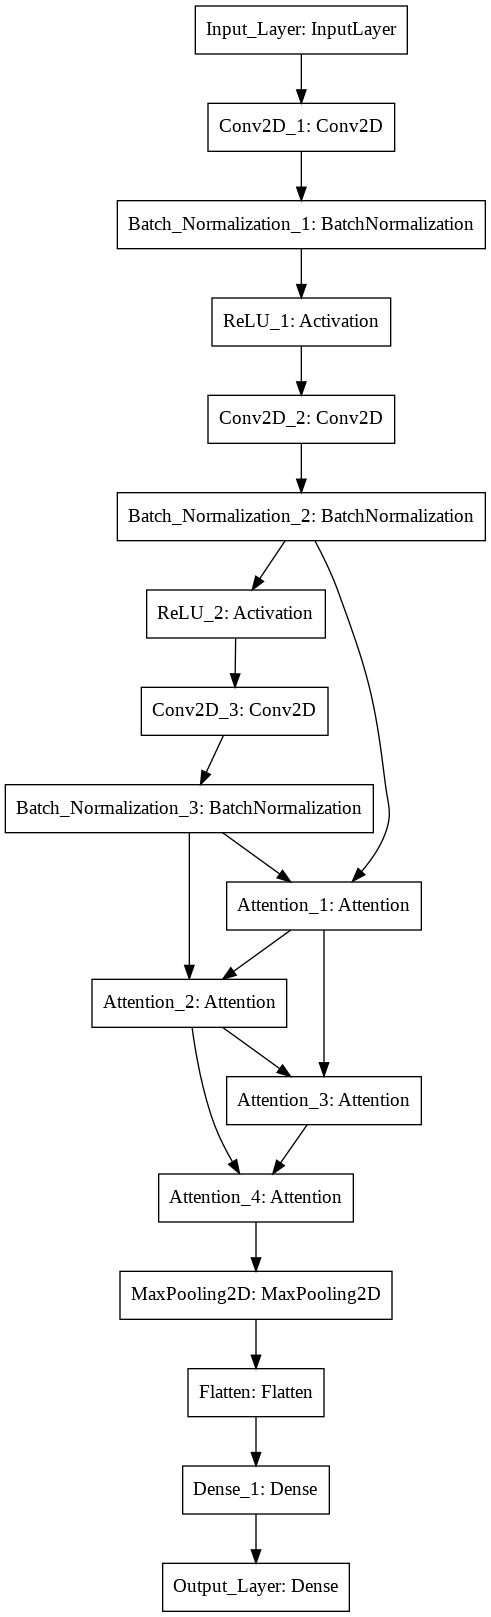

In [11]:
tf.keras.utils.plot_model(model)

## Callbacks

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
             EarlyStopping(monitor="val_accuracy",
                           min_delta=1e-4,
                           patience=15,
                           restore_best_weights=True)
]

## Fitting

In [13]:
history = model.fit(X_train, y_train,
                    epochs=1000, batch_size=128,
                    # steps_per_epoch=len(X_train)//32,
                    validation_data=(X_val, y_val),
                    # validation_steps=len(X_val)//32,
                    callbacks=callbacks)

Epoch 1/1000
422/422 [==============================] - 52s 52ms/step - loss: 0.6662 - accuracy: 0.7615 - val_loss: 1.1893 - val_accuracy: 0.5983
Epoch 2/1000
422/422 [==============================] - 22s 51ms/step - loss: 0.4198 - accuracy: 0.8485 - val_loss: 0.4137 - val_accuracy: 0.8528
Epoch 3/1000
422/422 [==============================] - 21s 51ms/step - loss: 0.3714 - accuracy: 0.8671 - val_loss: 0.3942 - val_accuracy: 0.8587
Epoch 4/1000
422/422 [==============================] - 21s 51ms/step - loss: 0.3417 - accuracy: 0.8760 - val_loss: 0.3573 - val_accuracy: 0.8697
Epoch 5/1000
422/422 [==============================] - 21s 51ms/step - loss: 0.3168 - accuracy: 0.8858 - val_loss: 0.3459 - val_accuracy: 0.8753
Epoch 6/1000
422/422 [==============================] - 22s 51ms/step - loss: 0.3051 - accuracy: 0.8896 - val_loss: 0.3478 - val_accuracy: 0.8757
Epoch 7/1000
422/422 [==============================] - 22s 51ms/step - loss: 0.2915 - accuracy: 0.8935 - val_loss: 0.3242 -

## Evaluation

In [14]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.3006 - accuracy: 0.9005


[0.3006191551685333, 0.9004999995231628]

## Visualizing history

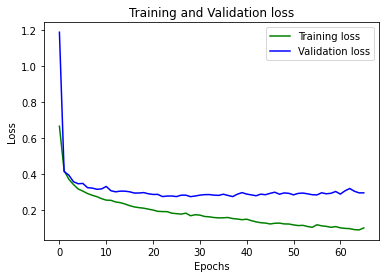

In [16]:
plt.plot(history.epoch, history.history['loss'], 'g', label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

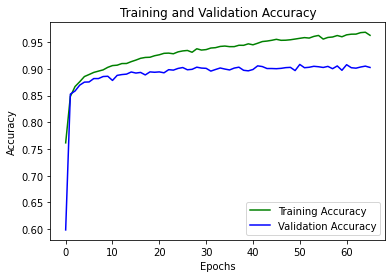

In [17]:
plt.plot(history.epoch, history.history['accuracy'], 'g', label='Training Accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();